# **Water Tank Management Model**

## Imports

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os

## File Names and Location

In [42]:
training_data_file = "data/training_dataset_1000.csv"
water_pump_model = "aqua_man_model.pkl"
water_pump_scaler = "aqua_man_scaler.pkl"
leak_detection_model = "leak_detector_model.pkl"
leak_detection_scaler = "leak_detector_scaler.pkl"
output_dir = 'model'

## Load and Prepare Data

In [43]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")
else:
    print(f"Directory '{output_dir}' already exists.")

print("\n=== Loading and Preparing Data ===")
try:
    df = pd.read_csv(training_data_file)
except FileNotFoundError:
    print("Error: 'training_dataset_01.csv' not found.")
    exit()

Directory 'model' already exists.

=== Loading and Preparing Data ===


### Convert timestamp

In [44]:
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df.dropna(subset=['timestamp'], inplace=True)
df['hour'] = df['timestamp'].dt.hour
df['level_change'] = df['water_level_percent'].diff()
df.fillna({'level_change':0}, inplace=True)

print(f"Data loaded successfully with {len(df)} valid rows.")
print("=" * 50)

Data loaded successfully with 96000 valid rows.


## Model 1: Pump Control (KNN)

In [45]:
print("\n--- Training Model 1: Pump Control (KNN) ---")


--- Training Model 1: Pump Control (KNN) ---


### Features & target

In [46]:
X_pump = df[['water_level_percent', 'hour', 'pump_state']]
y_pump = df['pump_signal_target']

### Split with class balance

In [47]:
X_train_pump, X_test_pump, y_train_pump, y_test_pump = train_test_split(
    X_pump, y_pump, test_size=0.3, random_state=42, stratify=y_pump
)

### Scale features

In [48]:
scaler_pump = StandardScaler()
X_train_pump_scaled = scaler_pump.fit_transform(X_train_pump)
X_test_pump_scaled = scaler_pump.transform(X_test_pump)

### Train KNN

In [49]:
pump_model = KNeighborsClassifier(n_neighbors=5, weights='distance')
pump_model.fit(X_train_pump_scaled, y_train_pump)
print("Pump control KNN model training complete.")

Pump control KNN model training complete.


### Save model & scaler

In [50]:
joblib.dump(pump_model, os.path.join(output_dir, water_pump_model))
joblib.dump(scaler_pump, os.path.join(output_dir, water_pump_scaler))
print(f"Saved {water_pump_model} and {water_pump_scaler} to '{output_dir}/'.")

Saved aqua_man_model.pkl and aqua_man_scaler.pkl to 'model/'.


### Evaluate

In [51]:
y_pred_pump = pump_model.predict(X_test_pump_scaled)
accuracy_pump = accuracy_score(y_test_pump, y_pred_pump)
print(f"Pump Model Accuracy: {accuracy_pump:.4f}")

print("\nPump Model Classification Report:")
print(classification_report(y_test_pump, y_pred_pump, target_names=['Pump OFF (0)', 'Pump ON (1)']))

Pump Model Accuracy: 0.9986

Pump Model Classification Report:
              precision    recall  f1-score   support

Pump OFF (0)       1.00      1.00      1.00     19848
 Pump ON (1)       1.00      1.00      1.00      8952

    accuracy                           1.00     28800
   macro avg       1.00      1.00      1.00     28800
weighted avg       1.00      1.00      1.00     28800



### Confusion Matrix

Saved confusion matrix to 'model/pump_knn_confusion_matrix.png'.


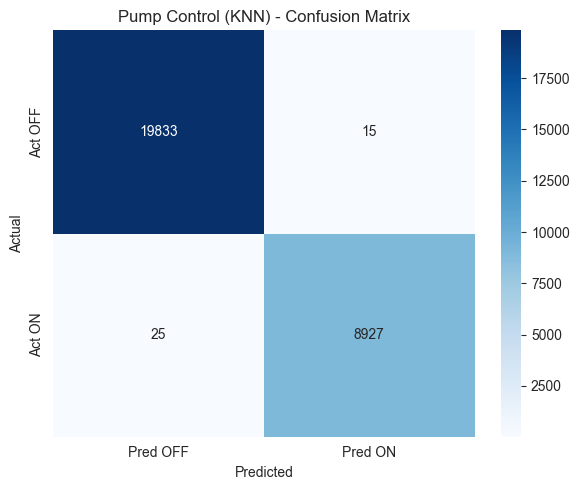

In [52]:
cm_pump = confusion_matrix(y_test_pump, y_pred_pump)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_pump, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred OFF', 'Pred ON'], yticklabels=['Act OFF', 'Act ON'])
plt.title('Pump Control (KNN) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'pump_knn_confusion_matrix.png'))
print(f"Saved confusion matrix to '{output_dir}/pump_knn_confusion_matrix.png'.")
print("=" * 50)

## Model 2: Leak Detection (KNN)

In [53]:
print("\n--- Training Model 2: Leak Detection (KNN) ---")


--- Training Model 2: Leak Detection (KNN) ---


### Features & target

In [54]:
X_leak = df[['hour', 'pump_state', 'level_change']]
y_leak = df['leak_detection_active_target']

### Split

In [55]:
X_train_leak, X_test_leak, y_train_leak, y_test_leak = train_test_split(
    X_leak, y_leak, test_size=0.3, random_state=42, stratify=y_leak
)

### Scale

In [56]:
scaler_leak = StandardScaler()
X_train_leak_scaled = scaler_leak.fit_transform(X_train_leak)
X_test_leak_scaled = scaler_leak.transform(X_test_leak)

### Train KNN

In [57]:
leak_model = KNeighborsClassifier(n_neighbors=7, weights='distance')
leak_model.fit(X_train_leak_scaled, y_train_leak)
print("Leak detection KNN model training complete.")

Leak detection KNN model training complete.


### Save model & scaler

In [58]:
joblib.dump(leak_model, os.path.join(output_dir, leak_detection_model))
joblib.dump(scaler_leak, os.path.join(output_dir, leak_detection_scaler))
print(f"Saved {leak_detection_model} and {leak_detection_scaler} to '{output_dir}/'.")

Saved leak_detector_model.pkl and leak_detector_scaler.pkl to 'model/'.


### Evaluate

In [59]:
y_pred_leak = leak_model.predict(X_test_leak_scaled)
accuracy_leak = accuracy_score(y_test_leak, y_pred_leak)
print(f"Leak Model Accuracy: {accuracy_leak:.4f}")

print("\nLeak Model Classification Report:")
print(classification_report(y_test_leak, y_pred_leak, target_names=['Mode INACTIVE (0)', 'Mode ACTIVE (1)']))

Leak Model Accuracy: 0.9991

Leak Model Classification Report:
                   precision    recall  f1-score   support

Mode INACTIVE (0)       1.00      1.00      1.00     26400
  Mode ACTIVE (1)       1.00      0.99      0.99      2400

         accuracy                           1.00     28800
        macro avg       1.00      1.00      1.00     28800
     weighted avg       1.00      1.00      1.00     28800



### Confusion Matrix

Saved confusion matrix to 'model/leak_knn_confusion_matrix.png'.

✅ All tasks complete using KNN.


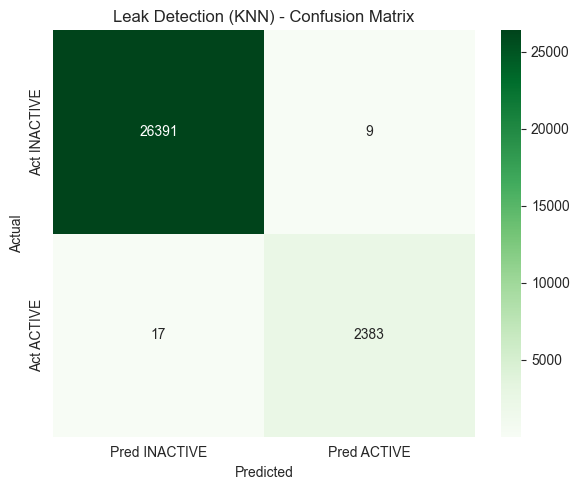

In [60]:
cm_leak = confusion_matrix(y_test_leak, y_pred_leak)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_leak, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred INACTIVE', 'Pred ACTIVE'],
            yticklabels=['Act INACTIVE', 'Act ACTIVE'])
plt.title('Leak Detection (KNN) - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'leak_knn_confusion_matrix.png'))
print(f"Saved confusion matrix to '{output_dir}/leak_knn_confusion_matrix.png'.")
print("=" * 50)

print("\n✅ All tasks complete using KNN.")